In [760]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RepeatedKFold,StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression 
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,roc_auc_score,roc_curve, precision_score,f1_score,auc,precision_recall_curve,classification_report

import seaborn as sns                  # For data visualization 
import matplotlib.pyplot as plt        # For plotting graphs 
%matplotlib inline 
import warnings                        # To ignore any warnings 
warnings.filterwarnings("ignore")
from xgboost import XGBClassifier

In [761]:
# My Customized wrapper Functions over Matplotlib and SeabornLib
import getPreProcessingFunction as PPM
import BiVEDA_Function as BiVEDA
import UniVEDA_catFunction as catUniVEDA
import UniVEDA_conti_methods as contiUniVEDA

In [762]:
TRdata=pd.read_csv("/Users/keeratjohar2305/Downloads/Dataset/data/train_loan_prediction_AV.csv")
TTdata=pd.read_csv("/Users/keeratjohar2305/Downloads/Dataset/data/test_loan_prediction_AV.csv")
ntrain=TRdata.shape[0]

In [763]:
TRdata.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [764]:
TRdata.shape,TTdata.shape

((614, 13), (367, 12))

In [765]:
label_col='Loan_Status'

In [766]:
df_all= pd.concat([TRdata, TTdata], ignore_index=True)
df_all[label_col]=df_all[label_col].map({'Y':1,'N':0})
TRdata.shape,TTdata.shape,df_all.shape

((614, 13), (367, 12), (981, 13))

In [767]:
# Data imputation

In [768]:
indMarrid=df_all[df_all['Married'].isnull()].index
df_all.loc[indMarrid,'Married']=TRdata['Married'].mode()[0]
df_all.loc[indMarrid,'Married']

indGender= df_all[df_all['Gender'].isnull()].index
df_all.loc[indGender,'Gender']=TRdata['Gender'].mode()[0]
df_all.loc[indGender,'Gender'].head()

IndSelfEmp=df_all[df_all['Self_Employed'].isnull()].index
df_all.loc[IndSelfEmp,'Self_Employed']=TRdata['Self_Employed'].mode()[0]
df_all.loc[IndSelfEmp,'Self_Employed'].head()

11    No
19    No
24    No
29    No
30    No
Name: Self_Employed, dtype: object

In [769]:
for colname in ['Credit_History', 'Dependents']:
    _IndexNo=df_all[df_all[colname].isnull()].index
    _mode=TRdata[colname].mode()[0]
    df_all.loc[_IndexNo,colname]=_mode
    print("imputation done for ",colname,_mode)


imputation done for  Credit_History 1.0
imputation done for  Dependents 0


In [770]:
dict1=dict(TRdata.groupby('Loan_Amount_Term')['LoanAmount'].median())
for i in dict1.keys():
    ind=df_all[(df_all['Loan_Amount_Term']==i) & (df_all['LoanAmount'].isnull())].index
    _mode=df_all[(df_all['Loan_Amount_Term']==i)]['LoanAmount'].median()
    df_all.loc[ind,'LoanAmount']=_mode
    print(i,ind,_mode)

12.0 Int64Index([], dtype='int64') 185.5
36.0 Int64Index([], dtype='int64') 118.0
60.0 Int64Index([], dtype='int64') 139.0
84.0 Int64Index([], dtype='int64') 108.0
120.0 Int64Index([], dtype='int64') 25.0
180.0 Int64Index([202, 605], dtype='int64') 118.0
240.0 Int64Index([435], dtype='int64') 100.0
300.0 Int64Index([], dtype='int64') 135.5
360.0 Int64Index([  0,  35,  63,  81,  95, 102, 103, 113, 127, 284, 305, 322, 338,
            387, 437, 479, 524, 550, 551, 692, 802, 861, 903],
           dtype='int64') 128.0
480.0 Int64Index([715], dtype='int64') 112.5


In [771]:
for colname in ['Loan_Amount_Term']:
    ind=df_all[df_all[colname].isnull()].index  
    _median=TRdata[colname].median()
    df_all.loc[ind,colname]=_median
    print(colname,_median,ind)

Loan_Amount_Term 360.0 Int64Index([ 19,  36,  44,  45,  73, 112, 165, 197, 223, 232, 335, 367, 421,
            423, 659, 662, 731, 743, 798, 828],
           dtype='int64')


In [772]:
PPM.desc1(df_all)

,dtypes,null_count,total count,unique_count,missing value ratio,variance of numerics,std,mean,min,max,skew,kurt
Credit_History,float64,0.0,981.0,2.0,0.00,0.13,0.36,0.85,0.0,1.0,-1.954,1.821
Education,object,0.0,981.0,2.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.000
Gender,object,0.0,981.0,2.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.000
Married,object,0.0,981.0,2.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.000
Self_Employed,object,0.0,981.0,2.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.000
Loan_Status,float64,367.0,614.0,2.0,37.41,0.22,0.46,0.69,0.0,1.0,-0.810,-1.348
Property_Area,object,0.0,981.0,3.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.000
Dependents,object,0.0,981.0,4.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.000
Loan_Amount_Term,float64,0.0,981.0,12.0,0.00,4157.93,64.48,342.56,6.0,480.0,-2.514,7.607
LoanAmount,float64,0.0,981.0,233.0,0.00,5837.70,76.40,142.05,9.0,700.0,2.764,11.978


# Feature engneering

In [773]:
def BiningContiCols_over_yBinary(contiColList,dataframe,bins=4):
    """
        Pass a list of continues columns , It will convert it into four bins and 

    """

    group=[i for i in range(1,bins+1)]
    dict1={'Low':1,'Average':2,'High':3, 'Very high':4}
    binsdf= pd.DataFrame()
    for conti_colname in contiColList:
        _colData=pd.DataFrame({conti_colname: dataframe[conti_colname]
                              },index=dataframe.index)
        _n_cols=pd.qcut(dataframe[conti_colname],q=bins,duplicates='drop').nunique()
        _colData['bins']=pd.qcut(dataframe[conti_colname], q=bins,duplicates='drop',labels=group[:_n_cols])
        
        binsdf[conti_colname+'_bins'] = _colData['bins']#.map(dict1)
        binsdf=binsdf.astype('int')
    return binsdf

In [774]:
df_all['ApplicantIncome']=df_all['ApplicantIncome'].astype('float')
df_all.drop('Loan_ID',1,inplace=True)

In [775]:
#PPM.desc1(df_all,2,label_col)

In [776]:
cat_temp=['Credit_History','Married','Education','Property_Area','Loan_Amount_Term','Gender','Dependents','Self_Employed']

In [777]:
# from sklearn.feature_selection import chi2
# import scipy.stats
# print(scipy.stats.chisquare(df_all['Self_Employed'].value_counts()))
# print(scipy.stats.chisquare(df_all['Married'].value_counts()))
# print(scipy.stats.chisquare(df_all['Gender'].value_counts()))
# print(scipy.stats.chisquare(df_all['Self_Employed'].value_counts()))
# print(scipy.stats.chisquare(df_all['Education'].value_counts()))


In [778]:
# conditions=[(df_all['Credit_History']==0)&(df_all['Education']=='Graduate') ,
#           (df_all['Credit_History']==0)&(df_all['Education']=='Not Graduate'),
#           (df_all['Credit_History']==1)&(df_all['Education']=='Not Graduate')]
# choices=[2,1,3]
# df_all['Credit_HistoryPerEdu']=np.select(conditions,choices,default=4)

In [779]:
import scipy.stats
def Ch2Test_CatAssociation_over_yCat(catColList,_label_col,_df):
    CH2_report=pd.DataFrame()
    for _i in catColList  :
        cont = pd.crosstab(_df[:ntrain][_i],_df[:ntrain][_label_col])
        statistic, p_value, dof, expected_frequency=scipy.stats.chi2_contingency(cont)
        series=pd.Series([_label_col,_i,statistic, round(p_value,3), dof, expected_frequency])
        CH2_report=CH2_report.append(series,ignore_index=True)
        #print(i,"\n p-Stats=",statistic, ",p-val=",p_value, ",dof=",dof, ",expected_frequency-\n" )
    
    #CH2_report['statistic'].plot.barh(figsize=(20,200))
    CH2_report.columns=['label_col','colname','statistic', 'p_value', 'dof', 'expected_frequency']    
    CH2_report.index=CH2_report['colname'].values
    CH2_report=CH2_report.sort_values('statistic')
    return CH2_report.sort_values('statistic',ascending=False)

# Feature Transofrmation

In [780]:
def FE_2Add_NewConti1(apply=1):
    if apply==1:
        df_all['TotalIncome']=df_all[['ApplicantIncome','CoapplicantIncome']].sum(1)
        df_all['TotalIncome/LoanAmount']=df_all[['ApplicantIncome','CoapplicantIncome']].sum(1)/df_all['LoanAmount']
        df_all['Loan_Amount_Term/LoanAmount']=df_all[['ApplicantIncome','CoapplicantIncome']].sum(1)/df_all['Loan_Amount_Term']
        #df_all['Loan_Amount_Term/LoanAmount']=df_all[['ApplicantIncome','CoapplicantIncome']].sum(1)/df_all['Loan_Amount_Term']
        #df_all['IncomeOverLoanAmount']=df_all[['ApplicantIncome','CoapplicantIncome']].sum(1)/300 - (df_all['LoanAmount']/df_all['Loan_Amount_Term'])

        ContiBins=BiningContiCols_over_yBinary(['LoanAmount', 'CoapplicantIncome', 'ApplicantIncome','Loan_Amount_Term/LoanAmount'],df_all,5)
        ContiBins=ContiBins.astype('object')
        df_all[ContiBins.columns]=ContiBins
        
#print(list(df_all.columns[df_all.dtypes=='float']))
conti_cols_FE=['Loan_Status','ApplicantIncome', 'CoapplicantIncome','LoanAmount','Loan_Amount_Term/LoanAmount','TotalIncome','TotalIncome/LoanAmount']


# When two features are independent, the observed count is close to the expected count, thus we will have smaller Chi-Square value. So high Chi-Square value indicates that the hypothesis of independence is incorrect. In simple words, higher the Chi-Square value the feature is more dependent on the response and it can be selected for model training.

In [781]:
# tempdf=pd.crosstab(df_all['ApplicantIncome_bins'],df_all['Credit_History']).reset_index()
# tempdf.columns=['ApplicantIncome_bins', 'CH-0.0', 'CH-1.0']
# tempdf.index=tempdf['ApplicantIncome_bins']
# tempdf=tempdf['CH-0.0']/tempdf['CH-1.0']
# df_all['ApplicantIncome_bins_CreditRatio']=df_all['ApplicantIncome_bins'].map(dict(tempdf))

In [782]:
def FE_2Add_CatMeanOverContiAggregation2(apply=1): 
    #tempdata=df_all.copy()
    if apply==1:
        conti_temp=['LoanAmount','CoapplicantIncome','ApplicantIncome','Loan_Amount_Term/LoanAmount']
        cat_temp=['Credit_History', 'Education', 'Gender', 'Married', 'Self_Employed','Property_Area',  'Dependents']
        bins_temp= ['LoanAmount_bins', 'ApplicantIncome_bins','CoapplicantIncome_bins','Loan_Amount_Term/LoanAmount_bins']

        for conti_colname in conti_temp:
            print(conti_colname)
            for cat_colname in cat_temp :
                for aggr in ['mean']:
                    #print(conti_colname,cat_colname,aggr)
                    tempAgg1=df_all[df_all[label_col]==1].groupby(cat_colname)[conti_colname].agg(aggr)
                    tempAgg0=df_all[df_all[label_col]==0].groupby(cat_colname)[conti_colname].agg(aggr)
                    tempAgg10=tempAgg1/tempAgg0
                    #tempdata[cat_colname+'0-'+aggr+'-over-'+conti_colname]=df_all[cat_colname].map(dict(tempAgg1))
                    #tempdata[cat_colname+'1-'+aggr+'-over-'+conti_colname]=df_all[cat_colname].map(dict(tempAgg0))
                    df_all[cat_colname+'1/0-'+aggr+'-over-'+conti_colname]=df_all[cat_colname].map(dict(tempAgg10))

    #df_all=tempdata.copy()
    #del tempdata
#FE_2Add_CatMeanOverContiAggregation(1)



In [783]:
def FE_2Add_CatFrequencyCount3(apply=1):
    if apply==1:
        for c in cat_temp:
            #df['count_'+c] = 
            dic=(dict(df_all[c].value_counts()))
            df_all['count_'+c]=(df_all[c].map(dic)).astype('int32')

In [784]:
def FE_2Add_CatFrequencyCount_divideBy_Loan_Amount_Term4(apply=1):
    if apply==1:
        for c in cat_temp:
           data['countexp_'+c] = (data[c].map(df_all[c].value_counts()))/data['Loan_Amount_Term']
           data['countexp_indx_div_'+c] = data['Loan_Amount_Term']/(data[c].map(data[c].value_counts()))

In [785]:
def FE_twoCatLabel_with_Binning5(apply=1):
    #pd.crosstab(data['Dependents'],data['Loan_Amount_Term'])
    if apply==1: 
        #1
        condi=[(data['Dependents'].isin(['3+','2'])) & (data['Loan_Amount_Term']<180),
               (data['Loan_Amount_Term']==350),
               (data['Dependents']=='3+') & (data['Loan_Amount_Term'].isin([240,350,480])),
               (data['Dependents']=='1') & (data['Loan_Amount_Term']<=60),

               (data['Dependents'].isin(['0','1','2'])) & (data['Loan_Amount_Term'].isin([84,240])),
               (data['Dependents'].isin(['1','2','3+'])) & (data['Loan_Amount_Term'].isin([300,480])),
               (data['Dependents']=='0') & (data['Loan_Amount_Term']<180),

               (data['Dependents'].isin(['1','2','3+'])) & (data['Loan_Amount_Term']==180),
               (data['Dependents'].isin(['0'])) & (data['Loan_Amount_Term'].isin([300,480])),

               (data['Dependents'].isin(['1','2','3+'])) & (data['Loan_Amount_Term']==360),

               (data['Dependents'].isin(['0'])) & (data['Loan_Amount_Term']==360)]
        choices=[1,1,2,2,2,3,3,4,4,5,5]
        data['DependentsWise_Loan_terms']=np.select(condi,choices,default=3)
        data['DependentsWise_Loan_terms_OT']=data['DependentsWise_Loan_terms'].astype('object')


        #2
        conditions=[(data['Loan_Amount_Term']<180.0)&(data['Education']=='Not Graduate')
                        ,(data['Loan_Amount_Term']>=180.0) &(data['Education']=='Not Graduate')
                        ,(data['Loan_Amount_Term']<180.0) &(data['Education']=='Graduate')
                        ]
        choices=[1,2,3]
        data['Edu_loan_Terms']=np.select(conditions,choices,default=4)
        data['Edu_loan_Terms_OT']=data['Edu_loan_Terms'].astype('object')

        #3
        conditions=[(data['Loan_Amount_Term']<180.0)&(data['Married']=='No')
                        ,(data['Loan_Amount_Term']>=180.0) &(data['Married']=='No')
                        ,(data['Loan_Amount_Term']<180.0) &(data['Married']=='Yes')
                        ]
        choices=[1,2,3]
        data['MarriedWise_loan_Terms']=np.select(conditions,choices,default=4)
        data['MarriedWise_loan_Terms_OT']=data['MarriedWise_loan_Terms'].astype('object')

        #4
        conditions=[(data['Loan_Amount_Term']>180.0)&(data['Property_Area']=='Semiurban')
                        ,(data['Loan_Amount_Term']<180.0) &(data['Property_Area']=='Urban')
                       ,(data['Loan_Amount_Term']<180.0) 

                        ]
        choices=[2,1,4]
        data['Property_AreaWise_loan_Terms']=np.select(conditions,choices,default=3)
        data['Property_AreaWise_loan_Terms_OT']=data['Property_AreaWise_loan_Terms'].astype('object')

        #5
        conditions=[(data['Loan_Amount_Term']<180.0)
                        ,(data['Loan_Amount_Term']>=180.0) &(data['Credit_History']==0.0)
                        ,(data['Loan_Amount_Term']>=180.0) &(data['Credit_History']==1.0)
                        ]

        choices=[1,2,2]
        data['Credit_History_loan_Terms']=np.select(conditions,choices,default=4)
        data['Credit_History_loan_Terms_OT']=data['Credit_History_loan_Terms'].astype('object')

        #6
        conditions=[(data['Loan_Amount_Term']<180.0)&(data['Gender']=='Female')
                        ,(data['Loan_Amount_Term']>=180.0) &(data['Gender']=='Female')
                        ,(data['Loan_Amount_Term']<180.0) &(data['Gender']=='Male')
                        ]
        choices=[1,2,3]
        data['GenderWise_loan_Terms']=np.select(conditions,choices,default=4)
        data['GenderWise_loan_Terms_OT']=data['GenderWise_loan_Terms'].astype('object')

        #7
        conditions=[(data['Loan_Amount_Term']>=0)&(data['Self_Employed']=='No')
                       ,(data['Loan_Amount_Term']<180.0) ]
        choices=[1,2]
        data['Self_EmployedWise_loan_Terms']=np.select(conditions,choices,default=3)
        data['Self_EmployedWise_loan_Terms_OT']=data['Self_EmployedWise_loan_Terms'].astype('object')

        #8
        conditions=[(data['Loan_Amount_Term']==360.0)]
        data['common_Loan_Amount_Term']=np.select(conditions,[2],default=1)
        data['common_Loan_Amount_Term_OT']=data['common_Loan_Amount_Term'].astype('object')

        #9
        data['Dependents']=data['Dependents'].map({"0":0,"1":1,"2":2,"3+":3})
        

In [786]:
FE_2Add_NewConti1(1)
FE_2Add_CatMeanOverContiAggregation2(1)
FE_2Add_CatFrequencyCount3(1)

#FE_2Add_CatFrequencyCount_divideBy_Loan_Amount_Term4(1)


# Normal Quintile Transsformation over ContiColumns to remove skewness
conti_cols_FE=['Loan_Status','ApplicantIncome', 'CoapplicantIncome','LoanAmount','Loan_Amount_Term/LoanAmount','TotalIncome','TotalIncome/LoanAmount']
NORMQUINT_TRANS=PPM.get_conti_cols_transformed(conti_cols_FE[1:],df_all,e=1,type='NQ')
data=df_all.copy()
data[NORMQUINT_TRANS.columns]=np.array(NORMQUINT_TRANS) 
FE_twoCatLabel_with_Binning5()




LoanAmount
CoapplicantIncome
ApplicantIncome
Loan_Amount_Term/LoanAmount
ApplicantIncome
CoapplicantIncome
LoanAmount
Loan_Amount_Term/LoanAmount
TotalIncome
TotalIncome/LoanAmount


In [787]:
# conti_temp1=['LoanAmount_bins', 'CoapplicantIncome_bins', 'ApplicantIncome_bins','Loan_Amount_Term/LoanAmount_bins']
# cat_temp1=['Credit_History','Married','Education','Property_Area','Loan_Amount_Term','Gender','Dependents','Self_Employed']
# Ch2Test_CatAssociation_over_yCat(conti_temp1+cat_temp1,label_col,df_all)

In [788]:
#pd.crosstab('Credit_History',data.'Loan_Amount_Term').mean(1),data['Education'])
#data[['Loan_Amount_Term','Credit_History']].count(1)

In [789]:
summy=PPM.desc1(data)
summy.head()
a1=summy[summy.unique_count<13].index

In [790]:
Ch2Test_CatAssociation_over_yCat(list(a1),label_col,data)

,label_col,colname,statistic,p_value,dof,expected_frequency
Loan_Status,Loan_Status,Loan_Status,609.355922,0.000,1.0,"[[60.039087947882734, 131.96091205211727], [13..."
Credit_History,Loan_Status,Credit_History,176.114575,0.000,1.0,"[[27.830618892508145, 61.16938110749186], [164..."
count_Credit_History,Loan_Status,count_Credit_History,176.114575,0.000,1.0,"[[27.830618892508145, 61.16938110749186], [164..."
Credit_History1/0-mean-over-LoanAmount,Loan_Status,Credit_History1/0-mean-over-LoanAmount,176.114575,0.000,1.0,"[[164.16938110749186, 360.83061889250814], [27..."
Credit_History1/0-mean-over-CoapplicantIncome,Loan_Status,Credit_History1/0-mean-over-CoapplicantIncome,176.114575,0.000,1.0,"[[164.16938110749186, 360.83061889250814], [27..."
Credit_History1/0-mean-over-ApplicantIncome,Loan_Status,Credit_History1/0-mean-over-ApplicantIncome,176.114575,0.000,1.0,"[[164.16938110749186, 360.83061889250814], [27..."
Credit_History1/0-mean-over-Loan_Amount_Term/LoanAmount,Loan_Status,Credit_History1/0-mean-over-Loan_Amount_Term/L...,176.114575,0.000,1.0,"[[164.16938110749186, 360.83061889250814], [27..."
Loan_Amount_Term,Loan_Status,Loan_Amount_Term,13.774252,0.131,9.0,"[[0.3127035830618892, 0.6872964169381107], [0...."
Property_AreaWise_loan_Terms_OT,Loan_Status,Property_AreaWise_loan_Terms_OT,12.895814,0.005,3.0,"[[1.5635179153094463, 3.436482084690554], [68...."
Property_AreaWise_loan_Terms,Loan_Status,Property_AreaWise_loan_Terms,12.895814,0.005,3.0,"[[1.5635179153094463, 3.436482084690554], [68...."


# Dummyfication

In [791]:
final_data=data.copy()
cat_cols=list(final_data.columns[final_data.dtypes=='object'])
print(cat_cols)

# Commenting it --- As this is use when we want to Linear Model
print(final_data.shape)
final_data[cat_cols]
dummiedDF=pd.get_dummies(final_data[cat_cols],cat_cols,drop_first=True)
final_data[dummiedDF.columns]=dummiedDF
final_data.drop(cat_cols,1,inplace=True)


# Lets drop all the columns in entire data where testing data columns holding single value
#### 4.1 Zero test for train and test data drop lowest variablity data
zerotest_testing_col=[]
for i in dummiedDF.columns:
    if i in final_data.columns:
        zerotest_cond=final_data[i][ntrain:].sum()==0
        if zerotest_cond:
            zerotest_testing_col.append(i)
print(len(zerotest_testing_col),"-",zerotest_testing_col)
if len(zerotest_testing_col) > 0:
   final_data.drop(zerotest_testing_col,1,inplace=True)
final_data.shape

# # Lets drop all the columns in entire data where training data columns holding single value
zerotest_training_col=[]
for i in dummiedDF.columns:
    if i in final_data.columns:
        zerotest_cond=final_data[i][:ntrain].sum()==0
        if zerotest_cond:
            zerotest_training_col.append(i)
print(len(zerotest_training_col),"-",zerotest_training_col)
if len(zerotest_training_col) > 0:
   final_data.drop(zerotest_training_col,1,inplace=True)
final_data.shape

['Education', 'Gender', 'Married', 'Property_Area', 'Self_Employed', 'LoanAmount_bins', 'CoapplicantIncome_bins', 'ApplicantIncome_bins', 'Loan_Amount_Term/LoanAmount_bins', 'DependentsWise_Loan_terms_OT', 'Edu_loan_Terms_OT', 'MarriedWise_loan_Terms_OT', 'Property_AreaWise_loan_Terms_OT', 'Credit_History_loan_Terms_OT', 'GenderWise_loan_Terms_OT', 'Self_EmployedWise_loan_Terms_OT', 'common_Loan_Amount_Term_OT']
(981, 71)
0 - []
0 - []


(981, 94)

# ch2 test on cat columns with targt label column
#### Lets check the influence of categorical columns on label col


In [792]:
# summy=PPM.desc1(final_data)
# cat_temp=summy[summy.unique_count<13].index
# cat_temp

In [793]:
# Ch2Test_Result=Ch2Test_CatAssociation_over_yCat(cat_temp,label_col,final_data)
# print(Ch2Test_Result.statistic.agg(['sum','mean']))
# Ch2Test_Result

# seperate train, label and test data

In [794]:
def statandardize(_label_col,_ntrain, _full_data,applyScale='minmax'):
    if _label_col in _full_data.columns:
        _ytrain=_full_data[_label_col][:_ntrain]
        _full_data=_full_data.drop([_label_col],1)
    # Feature Scaling
    _ytrain = pd.Series([int(i) for i in _ytrain])
    _xtrain=_full_data[:ntrain]
    _xtest=_full_data[ntrain:]
    
    if applyScale =='std':
        from sklearn.preprocessing import StandardScaler
        sc = StandardScaler()
        _xtrain = pd.DataFrame(sc.fit_transform(_xtrain),columns=_xtrain.columns)
        _xtest =  pd.DataFrame(sc.fit_transform(_xtest),columns=_xtest.columns)
    if applyScale =='minmax':
        from sklearn.preprocessing import MinMaxScaler
        sc = MinMaxScaler()
        _xtrain = pd.DataFrame(sc.fit_transform(_xtrain),columns=_xtrain.columns)
        _xtest =  pd.DataFrame(sc.fit_transform(_xtest),columns=_xtest.columns)

    return _xtrain,_ytrain,_xtest
xtrain,ytrain,xtest=statandardize(label_col,ntrain,final_data,'')   
def kbestCh2(ybinary,_xdata,k_value):
    from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif,f_classif
    #K beast ch2
    _ytrain = ybinary
    _xtrain = _xdata

    skb_ch2 = SelectKBest(chi2, k=k_value)
    skb_ch2.fit_transform(_xtrain, _ytrain)
    select_features_kbest = skb_ch2.get_support()

    kbest_ch2 = _xtrain.columns[select_features_kbest]
    scores = skb_ch2.scores_[select_features_kbest]
    feature_scoresdf = pd.DataFrame([(item, score) for item, score in zip(kbest_ch2, scores)], 
                                  columns=['feature', 'score']).sort_values(by='score', ascending=False)
    return feature_scoresdf.feature.values

In [795]:
# summy=PPM.desc1(xtrain)
# cat_temp=summy[summy.unique_count<13].index
# conti_temp=summy[summy.unique_count>=13].index


In [796]:
# pre=list(cat_temp)
# len(pre)

In [797]:
# ch2_rep=Ch2Test_CatAssociation_over_yCat(pre,label_col,final_data[:ntrain])
# ch2_rep[ch2_rep.statistic>0.5].index

In [798]:
# kbestCols=kbestCh2(ytrain,xtrain[pre],30)
# #kbestCols=ch2_rep[ch2_rep.statistic>4].index
# new_X=xtrain[conti_temp]
# new_X[kbestCols]=xtrain[kbestCols]
# xtrain=new_X.copy()

In [799]:
# set(pre).difference(kbestCols)

# model building start

 ##### 1. Cut down train data into traning data and validation data 

In [830]:
def statandardize(_label_col,_ntrain, _full_data,applyScale='minmax'):
    if _label_col in _full_data.columns:
        _ytrain=_full_data[_label_col][:_ntrain]
        _full_data=_full_data.drop([_label_col],1)
    # Feature Scaling
    _ytrain = pd.Series([int(i) for i in _ytrain])
    _xtrain=_full_data[:ntrain]
    _xtest=_full_data[ntrain:]
    
    if applyScale =='std':
        from sklearn.preprocessing import StandardScaler
        sc = StandardScaler()
        _xtrain = pd.DataFrame(sc.fit_transform(_xtrain),columns=_xtrain.columns)
        _xtest =  pd.DataFrame(sc.fit_transform(_xtest),columns=_xtest.columns)
    if applyScale =='minmax':
        from sklearn.preprocessing import MinMaxScaler
        sc = MinMaxScaler()
        _xtrain = pd.DataFrame(sc.fit_transform(_xtrain),columns=_xtrain.columns)
        _xtest =  pd.DataFrame(sc.fit_transform(_xtest),columns=_xtest.columns)

    return _xtrain,_ytrain,_xtest

def bestRFE(ybinary,_xdata,k_value):
    from sklearn.feature_selection import RFE
    from sklearn.svm import SVR
    #estimator = SVR(kernel="linear")
    model_RFE = LogisticRegression()
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    model_lda1 = LinearDiscriminantAnalysis()
    rfe = RFE(estimator=model_lda1, n_features_to_select=k_value, step=2)
    fit= rfe.fit(xtrain, ytrain)
    ranking_df = pd.DataFrame()
    ranking_df['Feature_name'] = xtrain.columns[fit.n_features_]
    return xtrain.columns[fit.support_]

def executeToFindBest_RFE_cols_usingTrainSplit():
    print(xtrain.shape)
    best_score=pd.DataFrame()
    for k in range(2,final_data.shape[1],2):

        xtrain,ytrain,xtest=statandardize(label_col,ntrain,final_data,'')
        colList=bestRFE(ytrain,xtrain,k)
        custom_train=xtrain[colList]
        x_train, x_cv, y_train, y_cv = train_test_split(custom_train,ytrain, test_size =0.3,random_state=0,stratify=ytrain)
        # model fitting
        model_lr = LogisticRegression() 
        model_lr.fit(x_train, y_train)
        model_dt = DecisionTreeClassifier(random_state=45) 
        model_dt.fit(x_train, y_train)

        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        model_lda = LinearDiscriminantAnalysis()
        model_lda.fit(x_train, y_train)

        # Predict
        ptrain = model_lr.predict(x_train)
        ptest = model_lr.predict(x_cv)
        ptrain_dt = model_dt.predict(x_train)
        ptest_dt = model_dt.predict(x_cv)
        ptrain_lda = model_lda.predict(x_train)
        ptest_lda = model_lda.predict(x_cv)
        #1. Accuracy Score
        #print("-----------RFE-----------" ,k, "--------- value-------------------")
        #print("\n\n\n-----------RFE-----------" ,k, "--------- value-------------------\n")
        #print("Logistic Regression:",accuracy_score(y_train,ptrain),accuracy_score(y_cv,ptest))
        #print("LDA:",accuracy_score(y_train,ptrain_lda),accuracy_score(y_cv,ptest_lda))
        #print("decisonTree:",accuracy_score(y_train,ptrain_dt),accuracy_score(y_cv,ptest_dt))
        best_score=best_score.append(pd.Series([k,'LogR',accuracy_score(y_train,ptrain),accuracy_score(y_cv,ptest)]),ignore_index=True)
        best_score=best_score.append(pd.Series([k,'LDA',accuracy_score(y_train,ptrain_lda),accuracy_score(y_cv,ptest_lda)]),ignore_index=True)
        best_score=best_score.append(pd.Series([k,'decisonTree',accuracy_score(y_train,ptrain_dt),accuracy_score(y_cv,ptest_dt)]),ignore_index=True)
    best_score.columns=['k-val','algo','train_accuracy','test_accuracy']
    best_score.sort_values(['train_accuracy','test_accuracy'],ascending=[False,False]).head()

    

In [849]:
############################# Main #########################################
def executeToFindBest_RFE_cols_usingCV(_cv=5):
    def _classificationModelfit_CV(_algo,_xdata,_ydata,_cv):
        from sklearn.model_selection import cross_validate
        _algo.fit(_xdata, _ydata)
        from sklearn.metrics import confusion_matrix
        cv_matrix_score= cross_validate(_algo, _xdata, _ydata, cv=_cv,
                                        scoring=('accuracy', 'precision', 'f1','recall', 'roc_auc','neg_log_loss'),
                                        return_train_score=True)
        avg_model_Scores=pd.DataFrame(cv_matrix_score).mean()
        for i in avg_model_Scores.index:
            if 'neg' in i :
                score="%s =%0.2f" %(i, avg_model_Scores[i]*-1) 
                #print(score)
            else:
                score="%s =%0.2f" %(i, avg_model_Scores[i] )
                #print(score)
        return avg_model_Scores
    
    def bestRFE(ybinary,_xdata,k_value):
        from sklearn.feature_selection import RFE
        #model_RFE = LogisticRegression()
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        model_lda = LinearDiscriminantAnalysis()
        rfe = RFE(estimator=model_lda, n_features_to_select=k_value, step=1)
        fit= rfe.fit(xtrain, ytrain)
        ranking_df = pd.DataFrame()
        ranking_df['Feature_name'] = xtrain.columns[fit.n_features_]
        return xtrain.columns[fit.support_]
    
    #####################   Main Program Decision tree ##############
    print(final_data.shape)
    best_score=pd.DataFrame()
    #for k in range(2,final_data.shape[1],2):
    for k in range(2,final_data.shape[1],2):
        xtrain,ytrain,xtest=statandardize(label_col,ntrain,final_data,'')
        colList=bestRFE(ytrain,xtrain,k)
        custom_train=xtrain[colList]
        
        model_lr = LogisticRegression()
        ser=_classificationModelfit_CV(model_lr, custom_train,ytrain,_cv)
        ser['Algo']='LogR'
        ser['RFE_Col_len']=k
        best_score=best_score.append(ser,ignore_index=True)
        

        model_dt = DecisionTreeClassifier(random_state=45) 
        ser=_classificationModelfit_CV(model_dt, custom_train,ytrain,_cv)
        ser['Algo']='DT'
        ser['RFE_Col_len']=k
        best_score=best_score.append(ser,ignore_index=True)
        
        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        model_lda = LinearDiscriminantAnalysis()        
        ser=_classificationModelfit_CV(model_lda, custom_train,ytrain,_cv)
        ser['Algo']='LDA'
        ser['best_RFE_Col_len']=k
        best_score=best_score.append(ser,ignore_index=True)

    return best_score.sort_values(['train_accuracy','test_accuracy'],ascending=[False,False]).head()
executeToFindBest_RFE_cols_usingCV(_cv=5)

(981, 94)


,Algo,RFE_Col_len,fit_time,score_time,test_accuracy,test_f1,test_neg_log_loss,test_precision,test_recall,test_roc_auc,train_accuracy,train_f1,train_neg_log_loss,train_precision,train_recall,train_roc_auc,best_RFE_Col_len
76,DT,52.0,0.006202,0.014129,0.737864,0.809448,-9.053976,0.813629,0.808067,0.695869,1.0,1.0,-9.992007e-16,1.0,1.0,1.0,NaN
64,DT,44.0,0.008256,0.017716,0.732946,0.804134,-9.223837,0.814191,0.798543,0.693739,1.0,1.0,-9.992007e-16,1.0,1.0,1.0,NaN
70,DT,48.0,0.006105,0.015143,0.731333,0.804462,-9.279549,0.807121,0.803305,0.688292,1.0,1.0,-9.992007e-16,1.0,1.0,1.0,NaN
61,DT,42.0,0.006226,0.013519,0.729561,0.803051,-9.340737,0.805724,0.803193,0.685537,1.0,1.0,-9.992007e-16,1.0,1.0,1.0,NaN
94,DT,64.0,0.008478,0.013656,0.724881,0.803475,-9.502393,0.790830,0.817535,0.669496,1.0,1.0,-9.992007e-16,1.0,1.0,1.0,NaN


In [883]:
def generate_submission_file(submission_csv_name,model,org_test,cleaned_test):
    y_pred = model.predict(cleaned_test)

    #Export submission file:
    org_test[label_col]=[int(i) for i in y_pred]
    submission=org_test[['Loan_ID',label_col]]
    submission[label_col]= submission[label_col].map({1:"Y",0:"N"})
#     negRec=len(submission[submission.Item_Outlet_Sales<0])
#     if negRec >0:
#         print("Output contain Negative records:", negRec)
#         submission.to_csv(submission_csv_name, index=False)
#         return submission[submission.Item_Outlet_Sales<0]
#     else:
    submission.to_csv(submission_csv_name, index=False)
        
    return submission[label_col]

def classificationModelfit_CV2(_algo,_xdata,_ydata,_cv):
    from sklearn.model_selection import cross_validate
    _algo.fit(_xdata, _ydata)
    #Perform cross-validation:
    from sklearn.metrics import confusion_matrix
    def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
    def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
    def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
    def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
#     scoring1 = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
#                 'fp': make_scorer(fp), 'fn': make_scorer(fn)}
    cv_matrix_score= cross_validate(_algo, _xdata, _ydata, cv=_cv,scoring=(
                         'accuracy', 
                         'precision',
                         'f1',
                         'recall',
                         'roc_auc',
                         'neg_log_loss',
                        
                          ),
                         return_train_score=True)
    avg_model_Scores=pd.DataFrame(cv_matrix_score).mean()
    for i in avg_model_Scores.index:
        if 'neg' in i :
            score="%s =%0.3f" %(i, avg_model_Scores[i]*-1) 
            #_df.loc[i]=np.sqrt(avg_model_Scores[i]*-1)
            print(score)
        else:
            score="%s =%0.3f" %(i, avg_model_Scores[i] )
            #_df.loc[i]=
            #avg_model_Scores[i]
            print(score)
    return avg_model_Scores

def DecisionTreeParamTuning(ybinary,_xdata,_cv,max_depth=[4,5],min_samples_split=[2,3,4]):
    def _classificationModelfit_CV(_algo,_xdata,_ydata,_cv):
        from sklearn.model_selection import cross_validate
        _algo.fit(_xdata, _ydata)
        from sklearn.metrics import confusion_matrix
        cv_matrix_score= cross_validate(_algo, _xdata, _ydata, cv=_cv,
                                        scoring=('accuracy', 'precision', 'f1','recall', 'roc_auc','neg_log_loss'),
                                        return_train_score=True)
        avg_model_Scores=pd.DataFrame(cv_matrix_score).mean()
        for i in avg_model_Scores.index:
            if 'neg' in i :
                score="%s =%0.2f" %(i, avg_model_Scores[i]*-1) 
                #print(score)
            else:
                score="%s =%0.2f" %(i, avg_model_Scores[i] )
                #print(score)
        return avg_model_Scores

    combi_code=0
    combi=[]
    _final_df=pd.DataFrame()
    for depth in max_depth:
        for samp_split in min_samples_split:
            combi_code=combi_code+1
            combi.append(str([depth,samp_split]))
            model_dt = DecisionTreeClassifier(random_state=22,max_depth=depth,min_samples_split=samp_split)
            result=_classificationModelfit_CV(model_dt, _xdata,ybinary,_cv)
            result['Combination_code_param']=combi_code
            result['param_combination']=str([depth,samp_split])
            _final_df=_final_df.append(pd.DataFrame(result).T)
            _final_df
    _final=_final_df[['test_accuracy','train_accuracy','test_f1','train_f1','test_roc_auc','train_roc_auc','Combination_code_param']].melt("Combination_code_param",var_name='Metrics',value_name="Values")
    #print(np.array(_final_df[['Combination_code_param','param_combination']]))
    plt.figure(figsize=(20,6))
    sns.pointplot(x="Combination_code_param", y="Values",hue="Metrics", data=_final)
    
    plt.xticks([i for i in range(1, combi_code+1)],combi,fontsize=15,rotation=80)
    plt.yticks(fontsize=15)
    plt.xlabel("param combination",fontsize=15)
    plt.ylabel("score value",fontsize=15)
    plt.legend(fontsize=20)
    return _final_df       

In [881]:
model_dt = DecisionTreeClassifier(random_state=22)#,max_depth=depth,min_samples_split=samp_split)
xtrain,ytrain,xtest=statandardize(label_col,ntrain,final_data,'')
RFE_cols=bestRFE(xtest,xtrain,52)
d=classificationModelfit_CV2(model_dt, xtrain[RFE_cols],ytrain,5)
xGBC_pred=generate_submission_file("n2.csv",model_dt,TTdata,xtest[RFE_cols])


fit_time =0.008
score_time =0.019
test_accuracy =0.748
train_accuracy =1.000
test_precision =0.809
train_precision =1.000
test_f1 =0.820
train_f1 =1.000
test_recall =0.834
train_recall =1.000
test_roc_auc =0.696
train_roc_auc =1.000
test_neg_log_loss =8.720
train_neg_log_loss =0.000


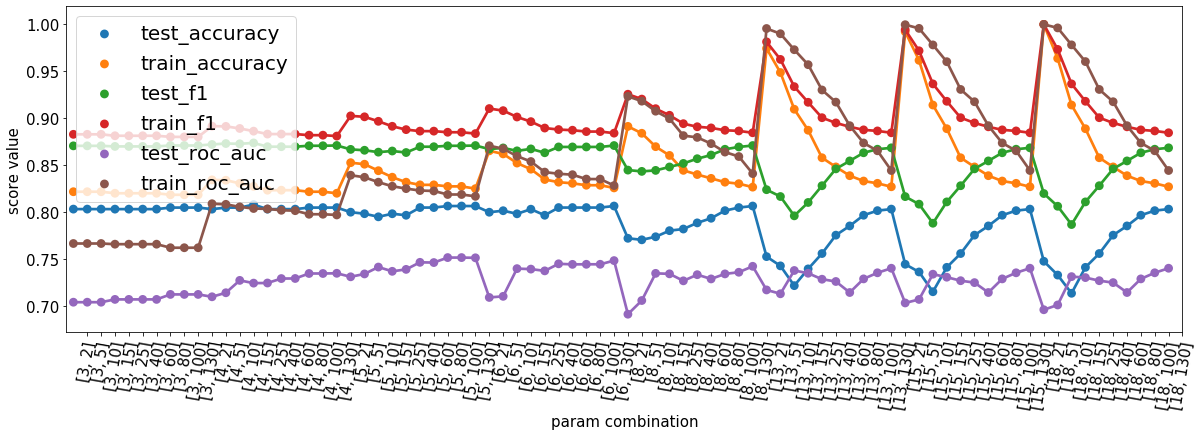

In [885]:
dt_score=DecisionTreeParamTuning(ytrain,xtrain[RFE_cols],5,max_depth=[3,4,5,6,8,13,15,18],min_samples_split=[2,5,10,15,25,40,60,80,100,130,])

In [891]:
dt_score.sort_values(['test_accuracy','train_accuracy'],ascending=[False,False]).head(3)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_f1,train_f1,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,Combination_code_param,param_combination
0,0.0266499,0.0749021,0.807959,0.827372,0.798763,0.810269,0.87366,0.886232,0.964482,0.978071,0.72425,0.803788,-0.857085,-0.42004,14,"[4, 15]"
0,0.024016,0.0852424,0.806425,0.827369,0.805058,0.816462,0.870623,0.885058,0.948011,0.966809,0.75148,0.81871,-0.64378,-0.423241,28,"[5, 80]"
0,0.0127716,0.044777,0.806425,0.827369,0.805058,0.816462,0.870623,0.885058,0.948011,0.966809,0.75148,0.81871,-0.64378,-0.423241,29,"[5, 100]"


In [893]:
dt_score.sort_values(['test_roc_auc','train_roc_auc'],ascending=[False,False]).head(3)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_f1,train_f1,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,Combination_code_param,param_combination
0,0.024016,0.0852424,0.806425,0.827369,0.805058,0.816462,0.870623,0.885058,0.948011,0.966809,0.75148,0.81871,-0.64378,-0.423241,28,"[5, 80]"
0,0.0127716,0.044777,0.806425,0.827369,0.805058,0.816462,0.870623,0.885058,0.948011,0.966809,0.75148,0.81871,-0.64378,-0.423241,29,"[5, 100]"
0,0.023,0.0571015,0.806425,0.824929,0.803885,0.814064,0.870889,0.883626,0.950392,0.966809,0.75123,0.816755,-0.541463,-0.428339,30,"[5, 130]"


In [898]:
model_dt = DecisionTreeClassifier(random_state=45,max_depth=5,min_samples_split=80)
xtrain,ytrain,xtest=statandardize(label_col,ntrain,final_data,'')
RFE_cols=bestRFE(xtest,xtrain,15)
d=classificationModelfit_CV2(model_dt, xtrain[RFE_cols],ytrain,5)
xGBC_pred=generate_submission_file("n2.csv",model_dt,TTdata,xtest[RFE_cols])


fit_time =0.006
score_time =0.024
test_accuracy =0.803
train_accuracy =0.810
test_precision =0.790
train_precision =0.793
test_f1 =0.872
train_f1 =0.877
test_recall =0.974
train_recall =0.980
test_roc_auc =0.730
train_roc_auc =0.793
test_neg_log_loss =0.652
train_neg_log_loss =0.452


In [911]:
def XGBClassifierParamTuning(ybinary,_xdata,_cv,learning_rate=[.1,.08,0.05,0.03,.01],n_estimators=[50,100,150,200,250,300,350,400,450,500]):
    def _classificationModelfit_CV(_algo,_xdata,_ydata,_cv):
        from sklearn.model_selection import cross_validate
        _algo.fit(_xdata, _ydata)
        from sklearn.metrics import confusion_matrix
        cv_matrix_score= cross_validate(_algo, _xdata, _ydata, cv=_cv,
                                        scoring=('accuracy', 'precision', 'f1','recall', 'roc_auc','neg_log_loss'),
                                        return_train_score=True)
        avg_model_Scores=pd.DataFrame(cv_matrix_score).mean()
        for i in avg_model_Scores.index:
            if 'neg' in i :
                score="%s =%0.2f" %(i, avg_model_Scores[i]*-1) 
                #print(score)
            else:
                score="%s =%0.2f" %(i, avg_model_Scores[i] )
                #print(score)
        return avg_model_Scores

    combi_code=0
    combi=[]
    _final_df=pd.DataFrame()
    for _lr in learning_rate:
        for n_est in n_estimators:
            combi_code=combi_code+1
            combi.append(str([_lr,n_est]))
            xgb1 = XGBClassifier(learning_rate =_lr, n_estimators=n_est, max_depth=5, min_child_weight=2, gamma=0, subsample=0.8,
                     colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
            result=_classificationModelfit_CV(xgb1, _xdata,ybinary,_cv)
            result['Combination_code_param']=combi_code
            result['param_combination']=str([_lr,n_est])
            _final_df=_final_df.append(pd.DataFrame(result).T)
            _final_df
#     _final=_final_df[['test_accuracy','train_accuracy','test_f1','train_f1','test_roc_auc','train_roc_auc','Combination_code_param']].melt("Combination_code_param",var_name='Metrics',value_name="Values")
#     #print(np.array(_final_df[['Combination_code_param','param_combination']]))
#     plt.figure(figsize=(20,6))
#     sns.pointplot(x="Combination_code_param", y="Values",hue="Metrics", data=_final)
    
#     plt.xticks([i for i in range(1, combi_code+1)],combi,fontsize=15,rotation=80)
#     plt.yticks(fontsize=15)
#     plt.xlabel("param combination",fontsize=15)
#     plt.ylabel("score value",fontsize=15)
#     plt.legend(fontsize=20)
    return _final_df       

In [912]:
xgb_score=XGBClassifierParamTuning(ytrain,xtrain[RFE_cols],5)

In [913]:
xgb_score.sort_values(['test_roc_auc','train_roc_auc'],ascending=[False,False]).head(3)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_f1,train_f1,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,Combination_code_param,param_combination
0,0.0698407,0.0269706,0.809572,0.809454,0.791409,0.790533,0.876821,0.876475,0.983417,0.983413,0.754982,0.806793,-0.497228,-0.474697,31,"[0.03, 50]"
0,0.121308,0.0256868,0.809572,0.809454,0.791409,0.790533,0.876821,0.876475,0.983417,0.983413,0.754982,0.80347,-0.518984,-0.50304,42,"[0.01, 100]"
0,0.23242,0.0303736,0.809572,0.809862,0.791409,0.79092,0.876821,0.87671,0.983417,0.983413,0.753714,0.807725,-0.489427,-0.460997,44,"[0.01, 200]"


In [915]:
xgb_score.sort_values(['test_accuracy','train_accuracy'],ascending=[False,False]).head(10)

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_f1,train_f1,test_recall,train_recall,test_roc_auc,train_roc_auc,test_neg_log_loss,train_neg_log_loss,Combination_code_param,param_combination
0,0.125856,0.028367,0.809572,0.810269,0.791409,0.7913,0.876821,0.876943,0.983417,0.983413,0.752457,0.810926,-0.487444,-0.448889,32,"[0.03, 100]"
0,0.0848114,0.0248134,0.809572,0.809862,0.791409,0.79092,0.876821,0.87671,0.983417,0.983413,0.750148,0.80925,-0.486948,-0.453465,21,"[0.05, 50]"
0,0.19189,0.0258083,0.809572,0.809862,0.791409,0.79092,0.876821,0.87671,0.983417,0.983413,0.752119,0.806415,-0.497769,-0.474954,43,"[0.01, 150]"
0,0.23242,0.0303736,0.809572,0.809862,0.791409,0.79092,0.876821,0.87671,0.983417,0.983413,0.753714,0.807725,-0.489427,-0.460997,44,"[0.01, 200]"
0,0.272845,0.0336688,0.809572,0.809862,0.791409,0.79092,0.876821,0.87671,0.983417,0.983413,0.750756,0.809248,-0.487208,-0.453483,45,"[0.01, 250]"
0,0.0698407,0.0269706,0.809572,0.809454,0.791409,0.790533,0.876821,0.876475,0.983417,0.983413,0.754982,0.806793,-0.497228,-0.474697,31,"[0.03, 50]"
0,0.0694537,0.0243909,0.809572,0.809454,0.791409,0.790533,0.876821,0.876475,0.983417,0.983413,0.752737,0.800385,-0.570193,-0.561487,41,"[0.01, 50]"
0,0.121308,0.0256868,0.809572,0.809454,0.791409,0.790533,0.876821,0.876475,0.983417,0.983413,0.754982,0.80347,-0.518984,-0.50304,42,"[0.01, 100]"
0,0.57231,0.0383132,0.807959,0.811083,0.790958,0.792064,0.875636,0.877409,0.981064,0.983413,0.744522,0.813773,-0.492624,-0.44288,49,"[0.01, 450]"
0,0.881954,0.0473974,0.807959,0.811083,0.790958,0.792064,0.875636,0.877409,0.981064,0.983413,0.743902,0.81523,-0.494007,-0.441528,50,"[0.01, 500]"


In [928]:
xgb1 = XGBClassifier(learning_rate =0.03, n_estimators=100, max_depth=5, min_child_weight=2, gamma=0, subsample=0.8,
                     colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
#modelfit(xgb1, train, predictors)
d=classificationModelfit_CV2(xgb1, xtrain,ytrain,5)
xGBC_pred=generate_submission_file("n2.csv",xgb1,TTdata,xtest)
# SCORING 7986


fit_time =0.429
score_time =0.049
test_accuracy =0.806
train_accuracy =0.858
test_precision =0.799
train_precision =0.840
test_f1 =0.872
train_f1 =0.904
test_recall =0.962
train_recall =0.979
test_roc_auc =0.765
train_roc_auc =0.960
test_neg_log_loss =0.476
train_neg_log_loss =0.331


In [951]:
xgb1 = XGBClassifier(learning_rate =0.01, n_estimators=350, max_depth=5, min_child_weight=2, gamma=1.1, subsample=0.8,
                     colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=.62, seed=27)
#modelfit(xgb1, train, predictors)
d=classificationModelfit_CV2(xgb1, xtrain,ytrain,5)
xGBC_pred=generate_submission_file("n2.csv",xgb1,TTdata,xtest)
# SCORING 0.8125
# Approach to Tune XGB
#1. roughly decide learning rate [0.1<> 0.01] 
#2. find the best estimators
#3. find the depth ... i have taken best max depth tunned during decision tree tuning
#4. find the best gamma
#5. find the best scale_pos_weight

fit_time =0.937
score_time =0.047
test_accuracy =0.800
train_accuracy =0.886
test_precision =0.808
train_precision =0.879
test_f1 =0.865
train_f1 =0.921
test_recall =0.931
train_recall =0.967
test_roc_auc =0.763
train_roc_auc =0.960
test_neg_log_loss =0.491
train_neg_log_loss =0.341


In [953]:
xgb1 = XGBClassifier(learning_rate =0.01, n_estimators=350, max_depth=5, min_child_weight=2, gamma=1.1, subsample=0.8,
                     colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=.70, seed=27,)
#modelfit(xgb1, train, predictors)
d=classificationModelfit_CV2(xgb1, xtrain,ytrain,5)
xGBC_pred=generate_submission_file("n2.csv",xgb1,TTdata,xtest)
# SCORING 0.8194
# Approach to Tune XGB
#1. roughly decide learning rate [0.1<> 0.01] 
#2. find the best estimators
#3. find the depth ... i have taken best max depth tunned during decision tree tuning
#4. find the best gamma
#5. find the best scale_pos_weight

fit_time =0.755
score_time =0.045
test_accuracy =0.800
train_accuracy =0.879
test_precision =0.807
train_precision =0.868
test_f1 =0.865
train_f1 =0.917
test_recall =0.934
train_recall =0.971
test_roc_auc =0.762
train_roc_auc =0.961
test_neg_log_loss =0.486
train_neg_log_loss =0.334


In [1000]:
xgb1 = XGBClassifier(learning_rate =0.01, n_estimators=350, max_depth=5, min_child_weight=2, gamma=1.1, subsample=0.8,
                     colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=.72, seed=27,
                     reg_alpha=.0003,reg_lambda=.008)
#modelfit(xgb1, train, predictors)
d=classificationModelfit_CV2(xgb1, xtrain,ytrain,5)
xGBC_pred=generate_submission_file("n2.csv",xgb1,TTdata,xtest)
# SCORING 0.8194
# Approach to Tune XGB
#1. roughly decide learning rate [0.1<> 0.01] 
#2. find the best estimators
#3. find the depth ... i have taken best max depth tunned during decision tree tuning
#4. find the best gamma
#5. find the best scale_pos_weight
#6. find the best reg_alpha

fit_time =0.987
score_time =0.048
test_accuracy =0.805
train_accuracy =0.889
test_precision =0.811
train_precision =0.878
test_f1 =0.868
train_f1 =0.924
test_recall =0.936
train_recall =0.974
test_roc_auc =0.762
train_roc_auc =0.970
test_neg_log_loss =0.488
train_neg_log_loss =0.309


In [ ]:
def statandardize(_label_col,_ntrain, _full_data,applyScale='minmax'):
    if _label_col in _full_data.columns:
        _ytrain=_full_data[_label_col][:_ntrain]
        _full_data=_full_data.drop([_label_col],1)
    # Feature Scaling
    _ytrain = pd.Series([int(i) for i in _ytrain])
    _xtrain=_full_data[:ntrain]
    _xtest=_full_data[ntrain:]
    
    if applyScale =='std':
        from sklearn.preprocessing import StandardScaler
        sc = StandardScaler()
        _xtrain = pd.DataFrame(sc.fit_transform(_xtrain),columns=_xtrain.columns)
        _xtest =  pd.DataFrame(sc.fit_transform(_xtest),columns=_xtest.columns)
    if applyScale =='minmax':
        from sklearn.preprocessing import MinMaxScaler
        sc = MinMaxScaler()
        _xtrain = pd.DataFrame(sc.fit_transform(_xtrain),columns=_xtrain.columns)
        _xtest =  pd.DataFrame(sc.fit_transform(_xtest),columns=_xtest.columns)

    return _xtrain,_ytrain,_xtest
  
def kbestCh2(ybinary,_xdata,k_value):
    from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif,f_classif
    #K beast ch2
    _ytrain = ybinary
    _xtrain = _xdata

    skb_ch2 = SelectKBest(chi2, k=k_value)
    skb_ch2.fit_transform(_xtrain, _ytrain)
    select_features_kbest = skb_ch2.get_support()

    kbest_ch2 = _xtrain.columns[select_features_kbest]
    scores = skb_ch2.scores_[select_features_kbest]
    feature_scoresdf = pd.DataFrame([(item, score) for item, score in zip(kbest_ch2, scores)], 
                                  columns=['feature', 'score']).sort_values(by='score', ascending=False)
    return feature_scoresdf.feature.values


########################### MainExecute2 ##########################

def MainExecute2():

    for k in range(2,56,2):
        xtrain,ytrain,xtest=statandardize(label_col,ntrain,final_data,'minmax') 
        colList=kbestCh2(ytrain,xtrain,k)
        custom_train=xtrain[colList]
        x_train, x_cv, y_train, y_cv = train_test_split(custom_train,ytrain, test_size =0.3,random_state=0,stratify=ytrain)
        # model fitting
        model_lr = LogisticRegression() 
        model_lr.fit(x_train, y_train)
        model_dt = DecisionTreeClassifier(random_state=45) 
        model_dt.fit(x_train, y_train)

        from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
        model_lda = LinearDiscriminantAnalysis()
        model_lda.fit(x_train, y_train)

        # Predict
        ptrain = model_lr.predict(x_train)
        ptest = model_lr.predict(x_cv)
        ptrain_dt = model_dt.predict(x_train)
        ptest_dt = model_dt.predict(x_cv)
        ptrain_lda = model_lda.predict(x_train)
        ptest_lda = model_lda.predict(x_cv)

        #1. Accuracy Score
        print("\n\n\n-----------RFE-----------" ,k, "--------- value-------------------\n")
        print("Logistic Regression:",accuracy_score(y_train,ptrain),accuracy_score(y_cv,ptest))
        print("LDA:",accuracy_score(y_train,ptrain_lda),accuracy_score(y_cv,ptest_lda))

        print("decisonTree:",accuracy_score(y_train,ptrain_dt),accuracy_score(y_cv,ptest_dt))
#MainExecute2()